In [1]:
import os
import json
import hoomd
import codecs

In [2]:
import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

In [3]:
from polykit.analysis import polymer_analyses, contact_maps
from polykit.generators.initial_conformations import grow_cubic

In [4]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = hoomd.device.GPU(gpu_ids=[3])

In [5]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 54397


In [6]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [7]:
# Simulate a chromosome comprised of 15000 monomers, with number density 0.2
density = 0.2
chromosome_sizes = [15000]

In [8]:
# Initialize simulation with the appropriate box size 
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density) ** (1/3.)

snapshot = build.get_simulation_box(box_length=L)

In [9]:
# Build random, dense initial conformations
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-2))

In [10]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes, monomer_type_list=['A'])

In [11]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [12]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [13]:
# Read input force parameters
with open("force_dict_homopolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "Harmonic"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.05
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 3.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [15]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [16]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces

In [17]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [18]:
# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)

In [19]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

In [23]:
gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(2000),
                             dynamic=['topology'],
                             mode='wb')

system.operations.writers.append(gsd_writer)

In [24]:
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           3523.33279     0:00:53.926215           1.01780          
       10000           3523.33279     0:00:53.926215           1.01780          
       20000           3902.20050     0:00:46.127819           1.02460          
       20000           3902.20050     0:00:46.127819           1.02460          
       30000           4117.43706     0:00:41.287820           1.01731          
       30000           4117.43706     0:00:41.287820           1.01731          
       40000           4233.43982     0:00:37.794325           1.01340          
       40000           4233.43982     0:00:37.794325           1.01340          
       50000           4306.66070     0:00:34.829770           1.01699          
       50000           4306.66070     0:00:34.829770           1.01699          
       60000           4356.22269     0:00:32.137935           1.02558          
       60000           4356.

In [29]:
import gsd
import numpy as np

from polychrom_hoomd.utils import unwrap_coordinates

trajectory = gsd.hoomd.open('trajectory.gsd', 'r')
rg2 = np.zeros(len(trajectory))

for i, snap in enumerate(trajectory):
    positions = unwrap_coordinates(snap)
    rg2[i] = polymer_analyses.Rg2(positions)

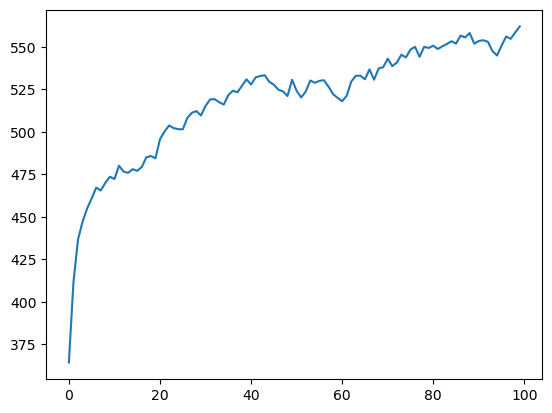

In [30]:
import matplotlib.pyplot as plt

plt.plot(rg2)